A notebook for capturing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Capturing dark frames only at a higher blacklevel, to check if this has an effect on the observed read noise. 

Try on multiple black levels and save outputs.

Here try range of 10 -> 0, taking 10 first and decreasing, to check effect of order of sequence on read noise.

# Camera Setup

Here we configure and setup the camera capture objects.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras, black_level=0)

Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 2 (DMK 33GX249 10910289) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
1
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 0
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0


In [3]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from time import sleep

Here we are only going to process images over the calibration target itself, so we restrict the ROI to a very small field of 32x32 pixels.
Statistics are therfore computed over 1024 pixels in each case.

# Calibration Functions

Here we define simple functions for controlling the cameras during the calibration routines.

In [4]:
def camera_calibration_sequence(camera, subject) -> pd.DataFrame:
    """Capture pairs of images with increasing exposure time until all
    pixels are saturated, then decrease exposure time until no pixels are 
    saturated.
    
    Args:
        camera: Camera object to capture images from.
    
    Returns:
        DataFrame with columns:
            - exposure
            - mean
            - std
    """
    camera.set_property('Exposure', 'Auto', 0, 'Switch')        
    t_min = 1.0/16666 # (seconds) verify that this is the minimum exposure time
    t_max = 20.0
    t_exp = t_min
    up_scale = 1.2
    dwn_scale = 0.99
    t_scale = up_scale
    img_type='calibration'
    stop = False    
    cmd_exposures = []
    exposures = []
    means = []
    stds = []
    shots = []
    sat_val = camera.max_dn
    while stop is False:
        print(f'Exposure: {t_exp:.7f} s')
        camera.set_property('Exposure', 'Value', t_exp, 'AbsoluteValue')
        img_1 = camera.image_capture(roi=True)
        # sleep(0.5)
        img_2 = camera.image_capture(roi=True)
        # sleep(0.5)
        name_1 = f'{t_exp*1E6:.0f}us_1'
        name_2 = f'{t_exp*1E6:.0f}us_2'
        camera.save_image(name_1, subject, img_type, img_1)
        camera.save_image(name_2, subject, img_type, img_2)
        exposures.append(camera.get_exposure_value())
        cmd_exposures.append(t_exp)
        mean = np.mean([np.mean(img_1), np.mean(img_2)])
        std = np.mean([np.std(img_1), np.std(img_2)])
        shot = np.sqrt(np.mean((img_1 - img_2)**2)/2)
        means.append(mean)
        stds.append(std)
        shots.append(shot)
        if mean >= sat_val * 0.999:
            t_scale = dwn_scale
        if t_scale == dwn_scale:
            # n_sat = (np.sum(img_1 == sat_val) + np.sum(img_2 == sat_val)) / 2
            if mean <= sat_val * 0.80:
                stop = True
        else:
            if t_exp*t_scale > t_max:
                t_scale = dwn_scale
        t_exp = t_exp * t_scale

    results = pd.DataFrame({'exposure': exposures, 'raw mean': means, 'raw standard deviation': stds, 'shot and read noise': shots, 'cmd exposure': cmd_exposures})
    results.sort_values('exposure', inplace=True)

    print(results)

    cwl_str = str(int(camera.camera_props['cwl']))
    channel = str(camera.camera_props['number'])+'_'+cwl_str
    subject_dir = Path('..', 'data', subject, channel)
    subject_dir.mkdir(parents=True, exist_ok=True)
    filename = 'exposures.csv'
    img_file =str(Path(subject_dir, filename).with_suffix('.tif'))

    results['exposure'].to_csv(f'{subject}_exposures.csv', index=False)

    fig, ax = plt.subplots(2,1, figsize=(5,10))
    ax[0].plot(results['exposure'], results['raw mean'], label='Ret.')
    ax[0].plot(results['cmd exposure'], results['raw mean'], label='Cmd.')
    ax[0].set_xlabel('Exposure (s)')
    ax[0].set_ylabel('Mean Pixel Value')
    results.sort_values('raw mean', inplace=True)
    ax[1].loglog(results['raw mean'], results['raw standard deviation'], label='Total Noise')
    ax[1].loglog(results['raw mean'], results['shot and read noise'], label='Shot and Read Noise')
    ax[1].set_xlabel('Mean Pixel Value')
    ax[1].set_ylabel('Standard Deviation')
    plt.show()
    return cmd_exposures

# Dark Signal Procedure

Output:
- Dark Exposure List
- Dark Image Directory

setting black level to 10 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 10
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.015625
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI current Enable

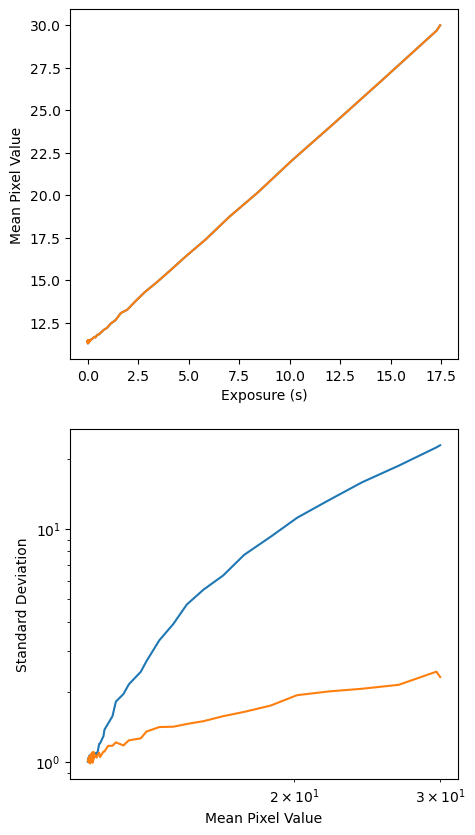

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

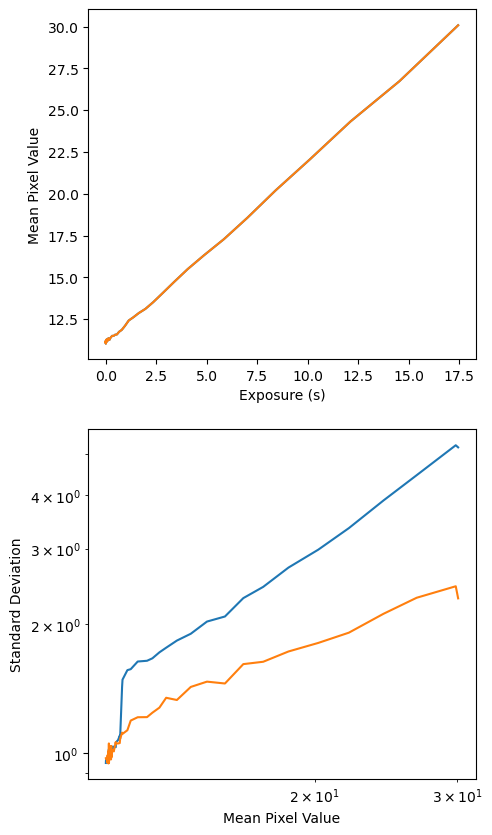

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

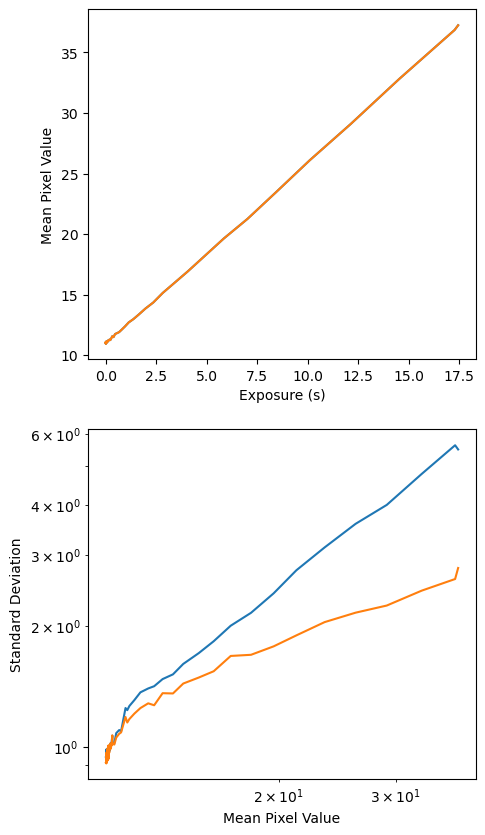

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

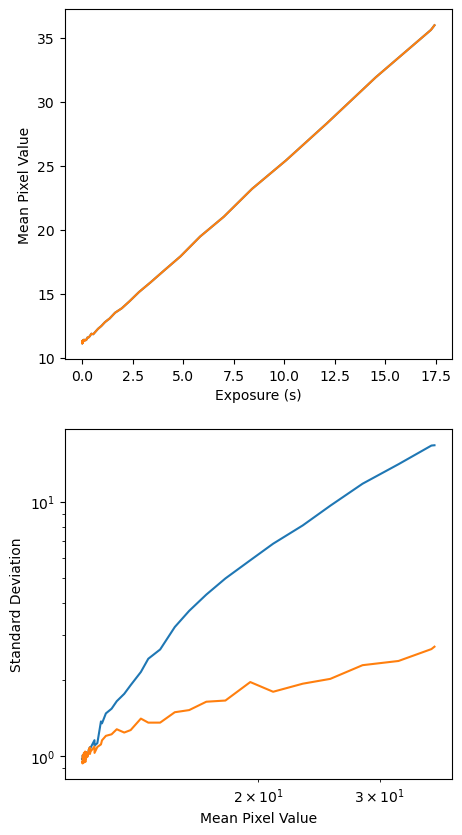

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

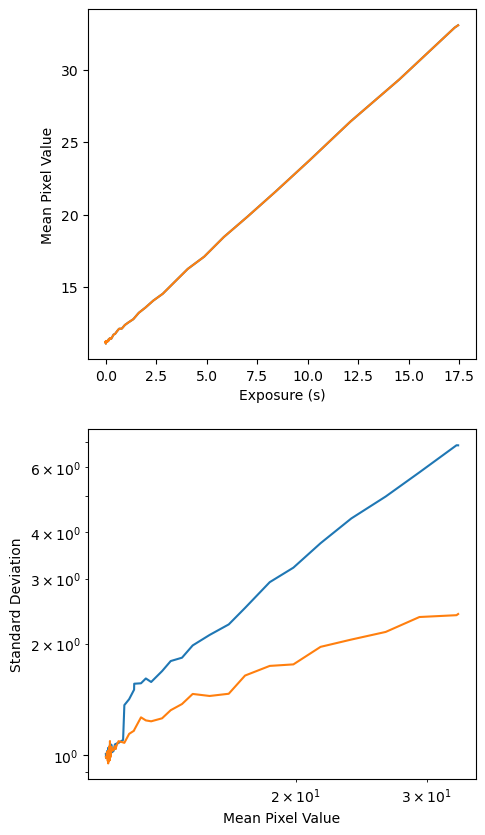

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

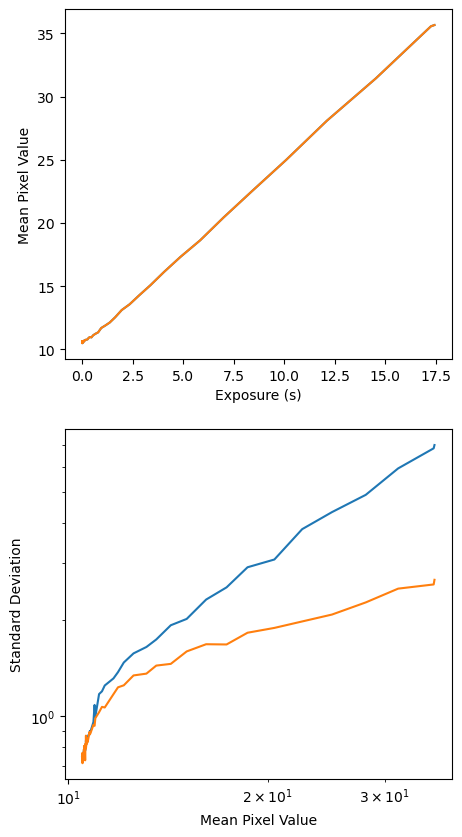

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

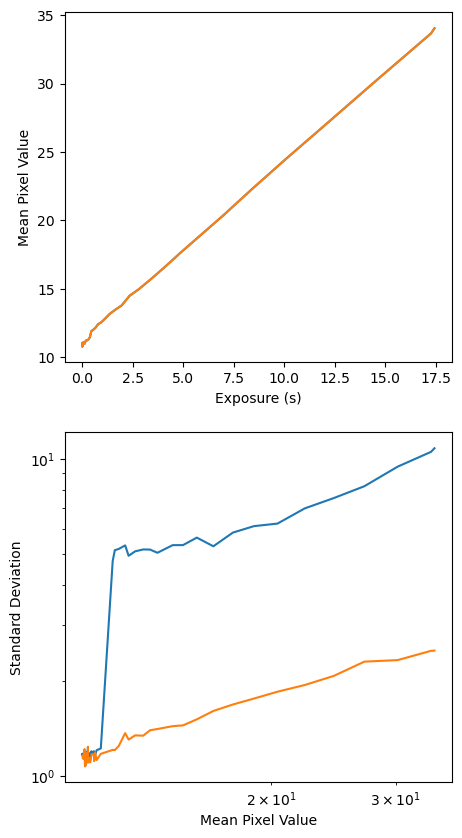

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_10_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_10_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_10_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_10_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Expos

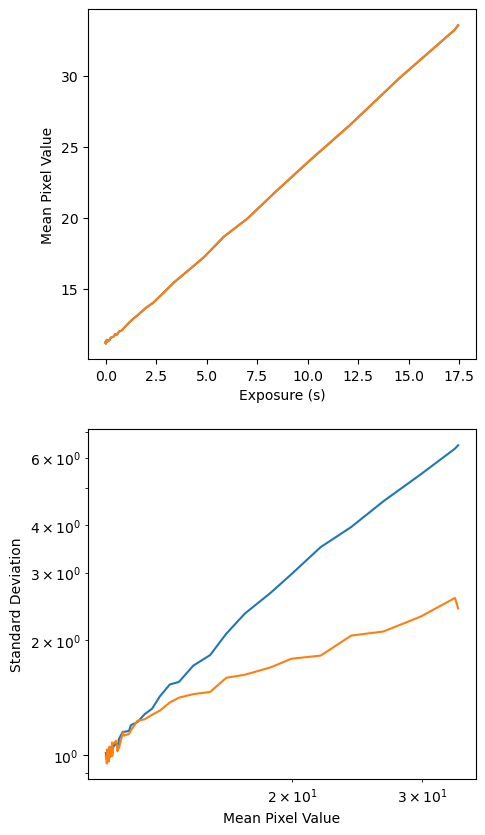

setting black level to 9 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 9
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

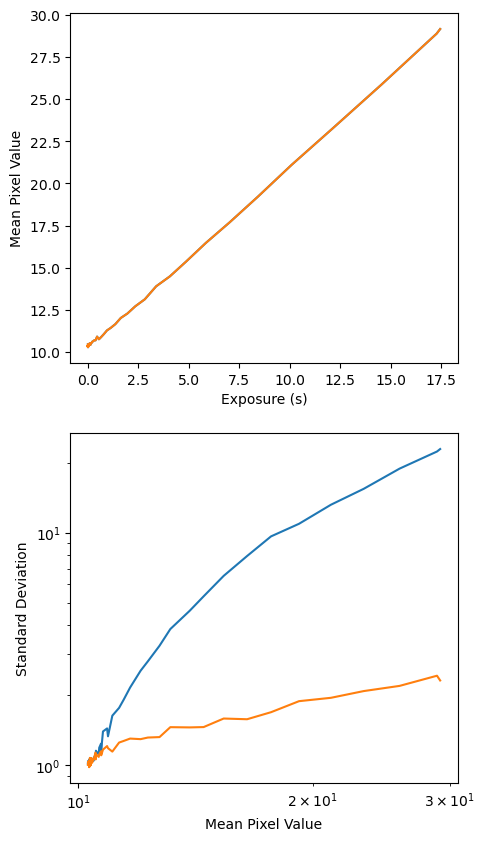

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

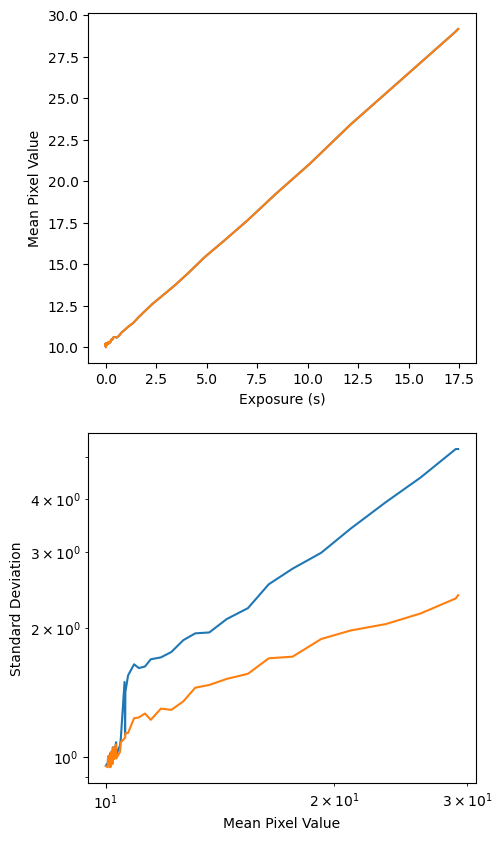

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

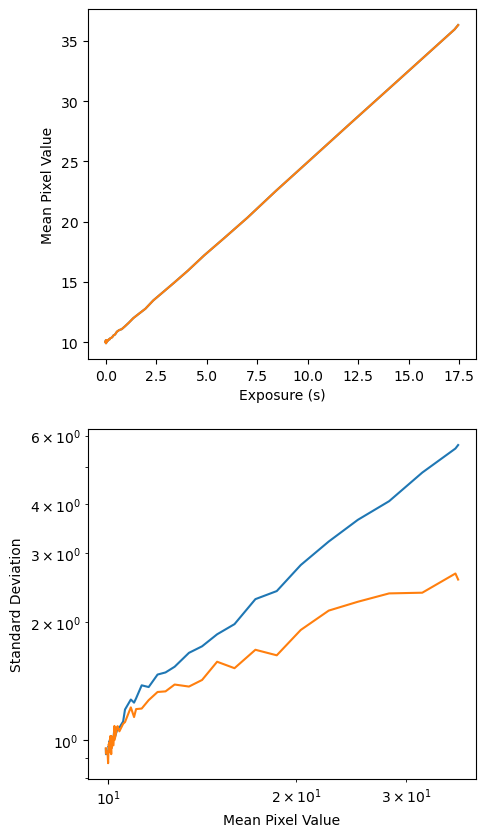

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

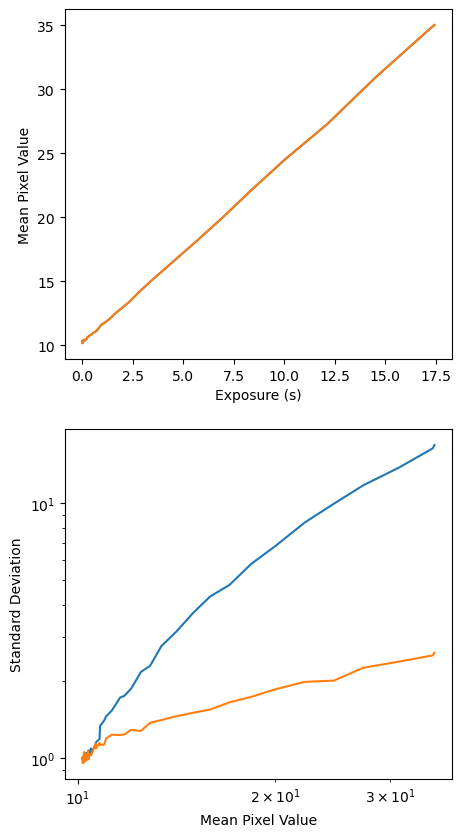

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

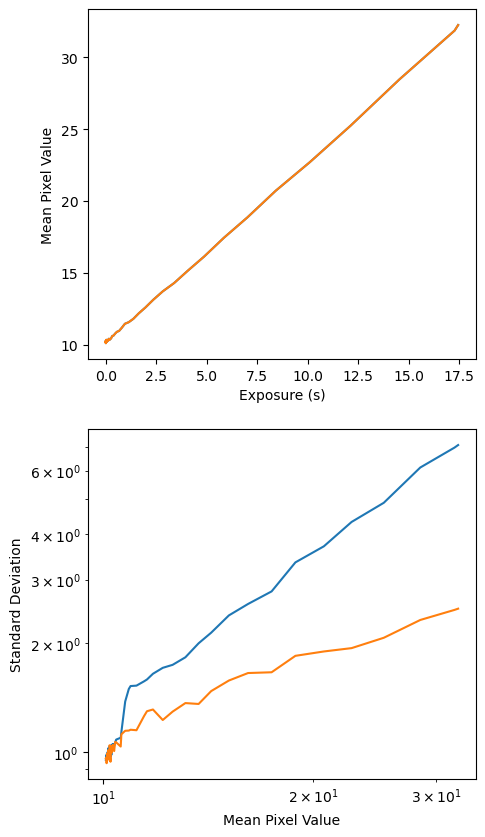

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

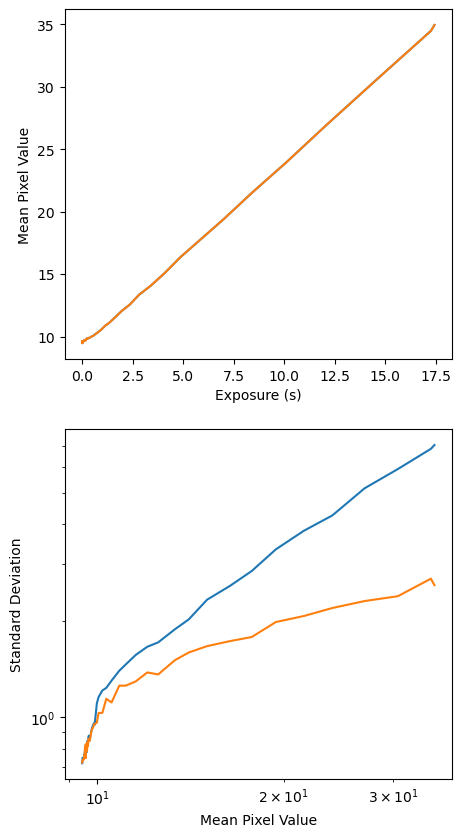

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

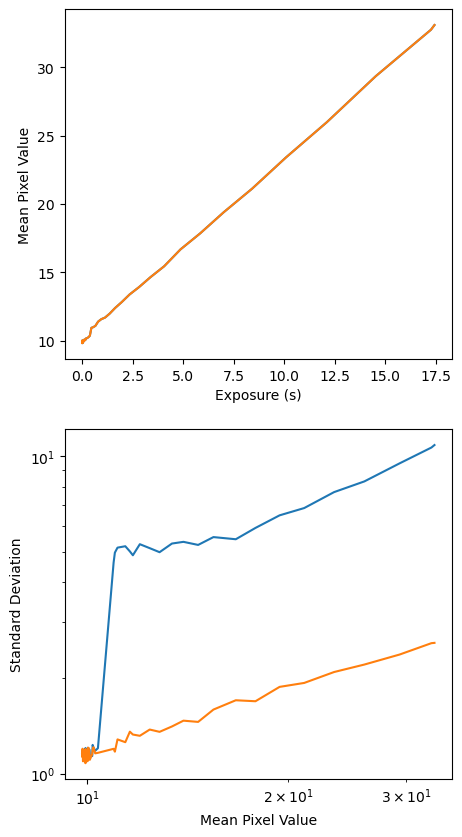

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_9_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_9_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_9_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_9_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

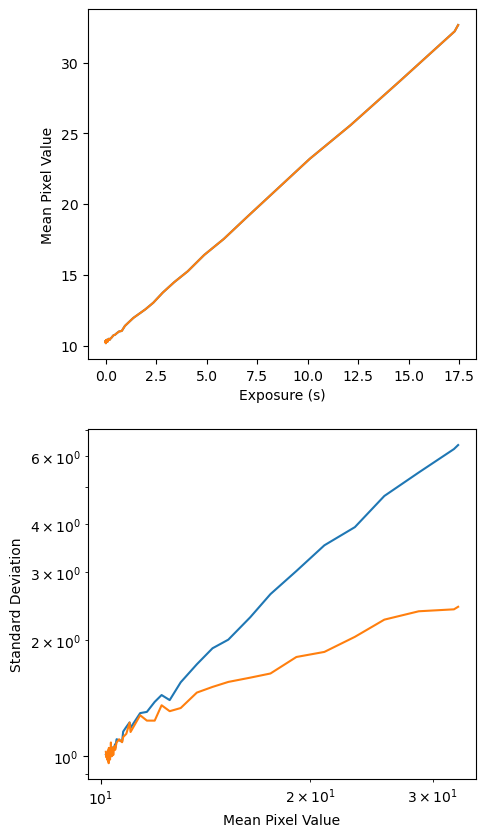

setting black level to 8 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 8
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

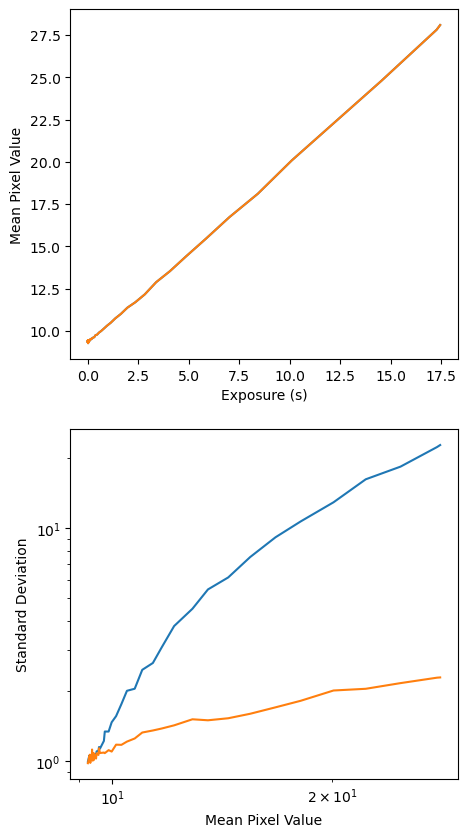

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

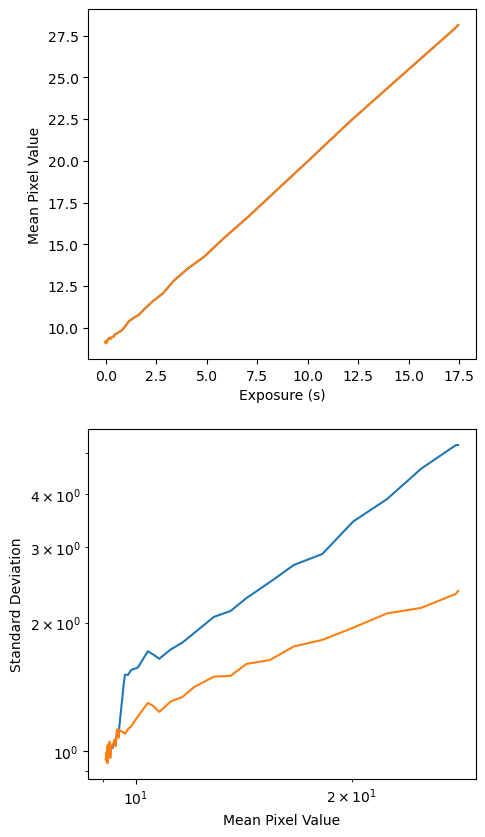

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

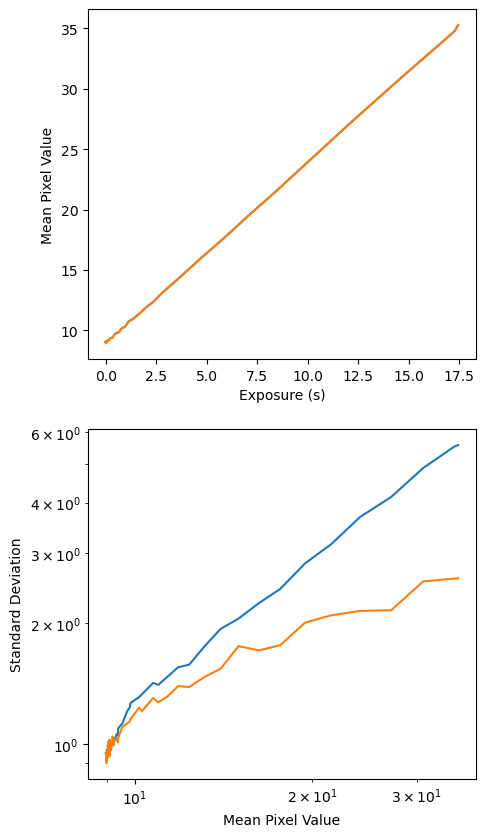

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

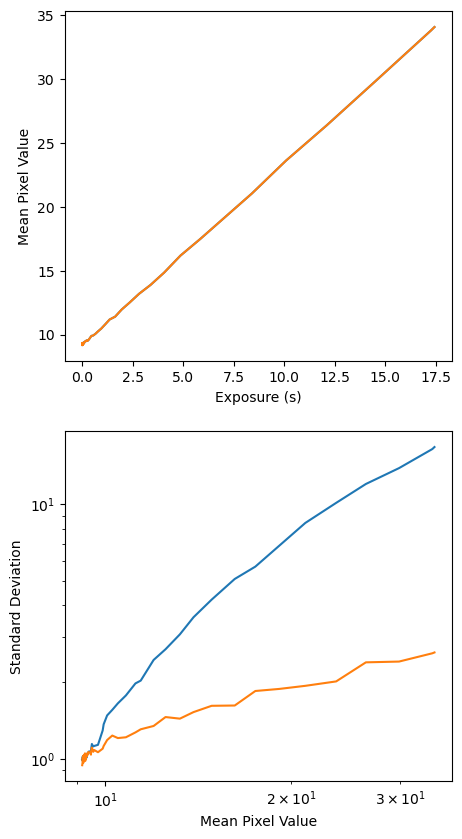

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

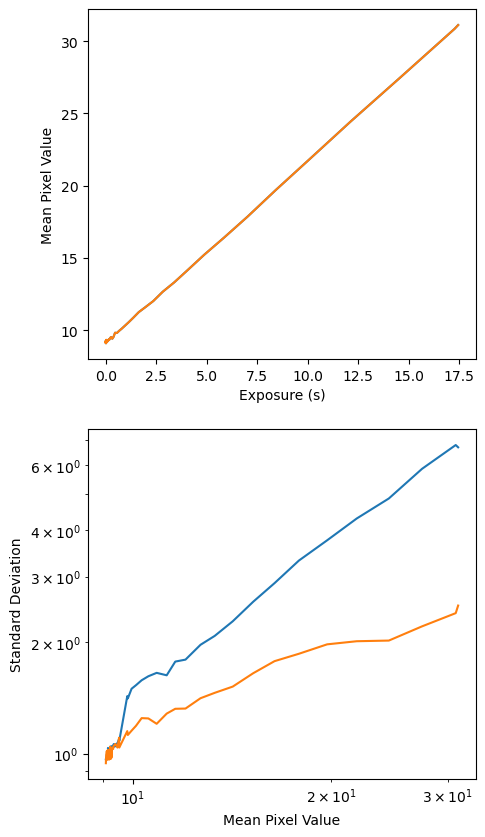

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

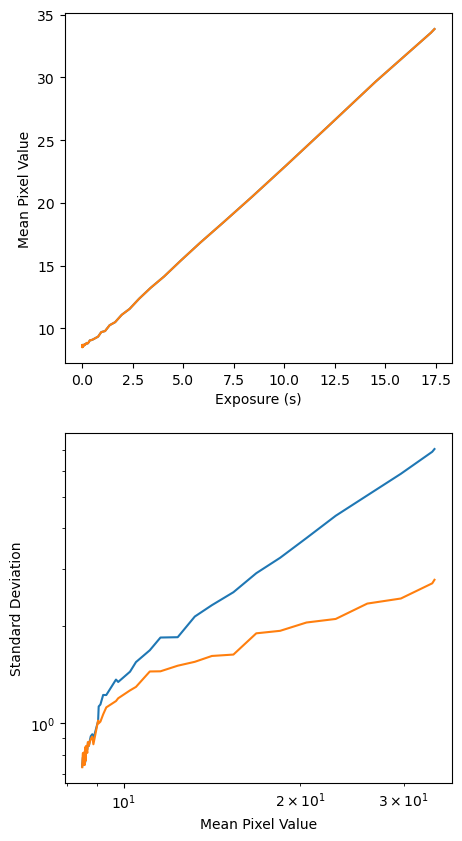

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

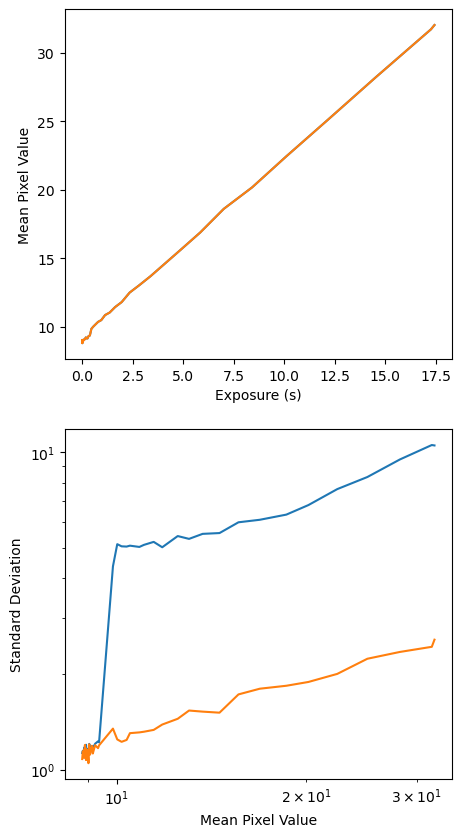

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_8_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_8_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_8_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_8_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

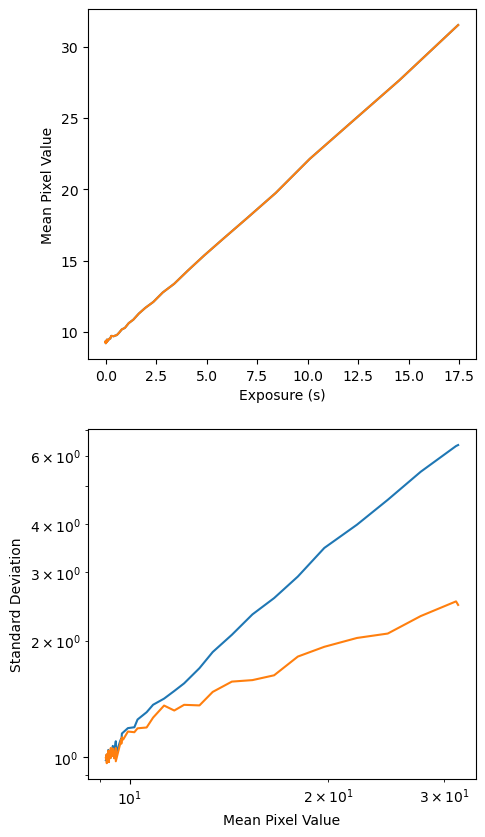

setting black level to 7 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 7
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

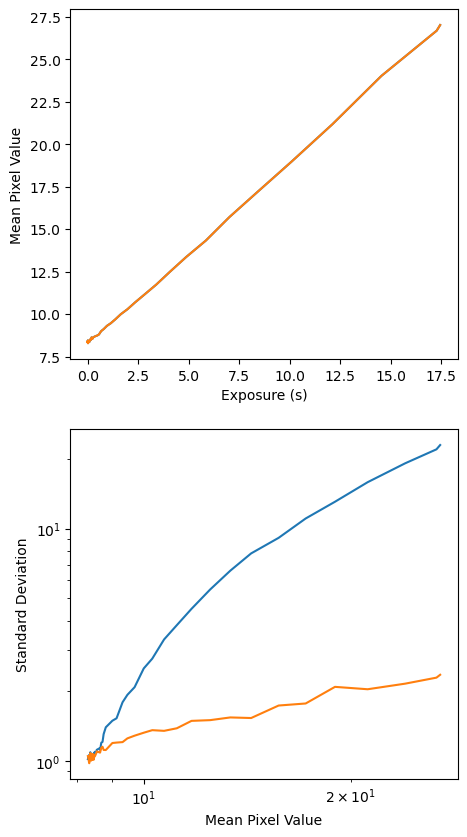

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

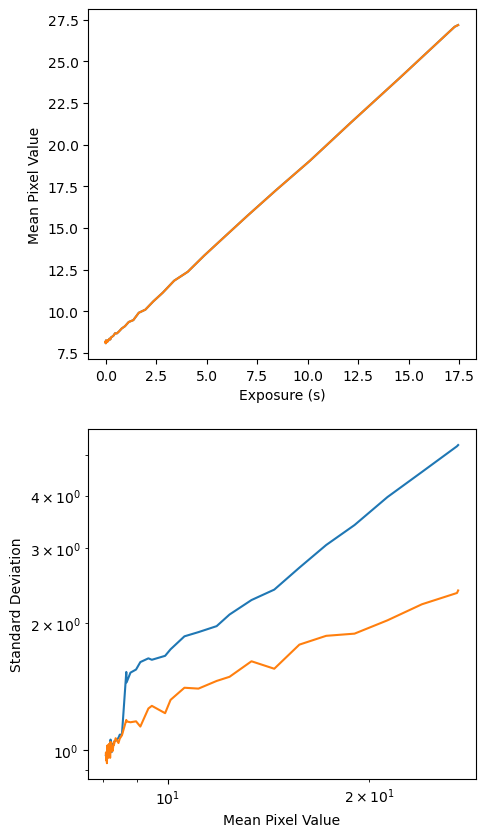

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

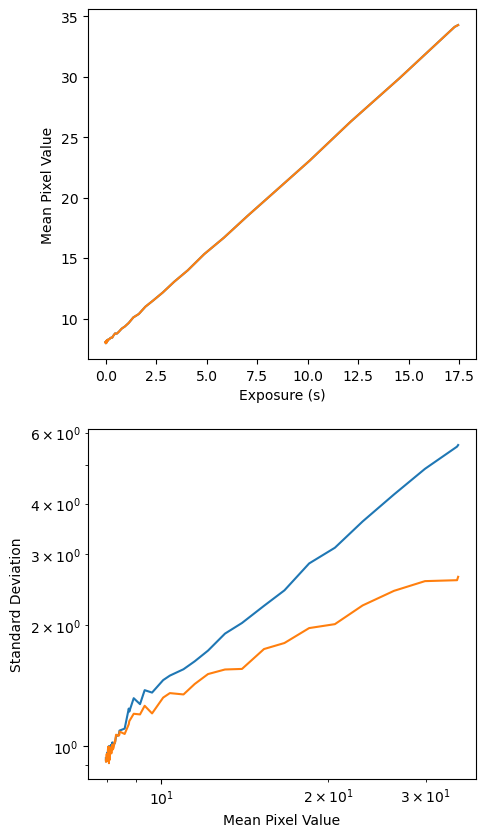

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

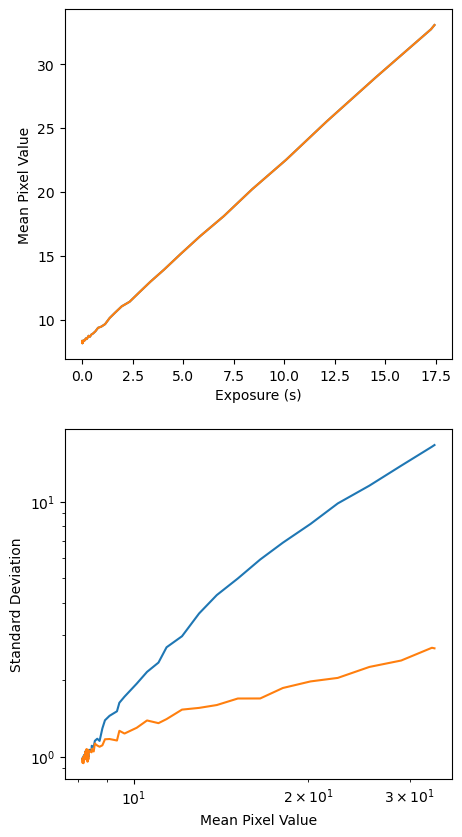

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

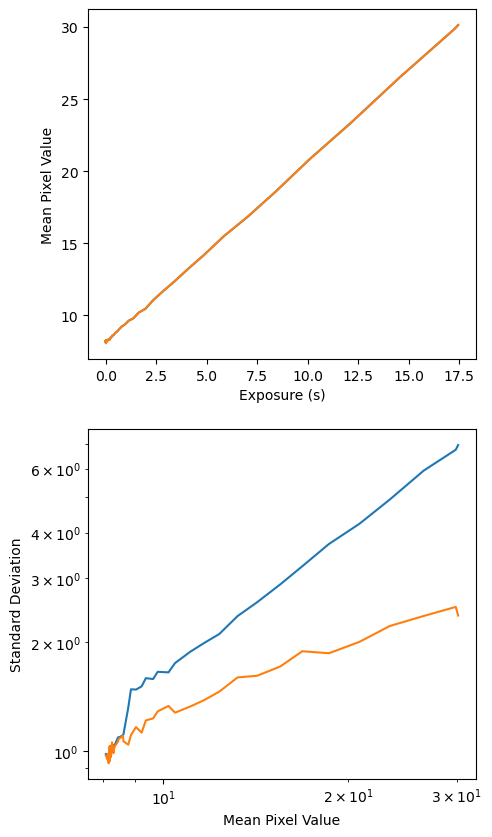

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

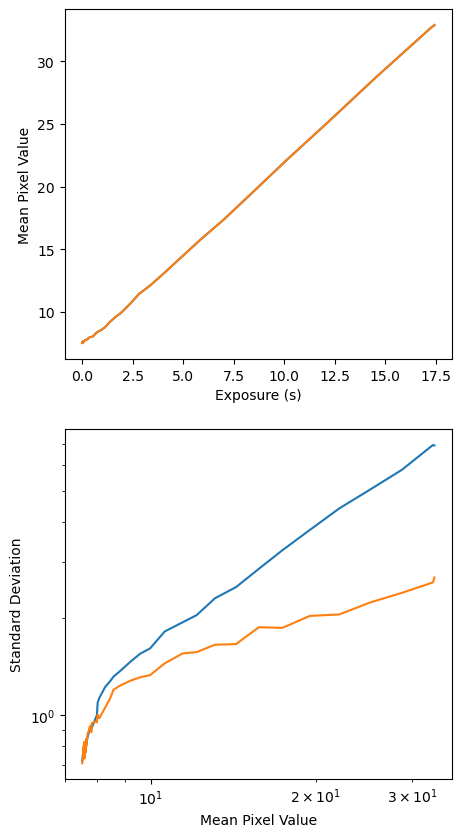

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

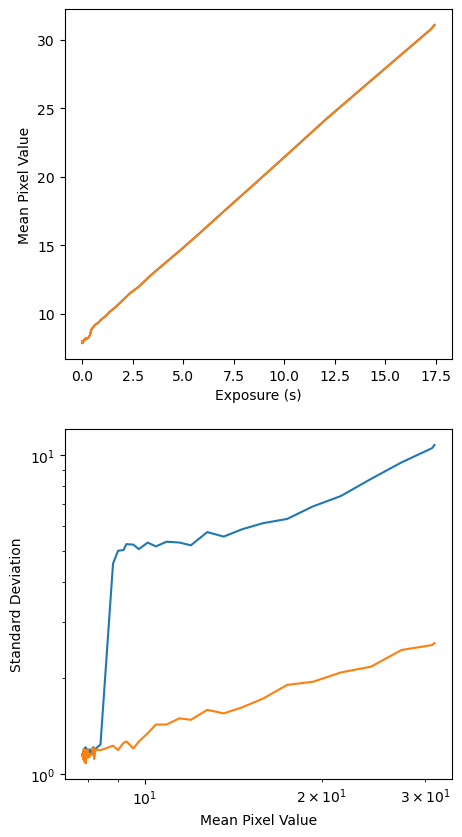

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_7_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_7_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_7_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_7_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

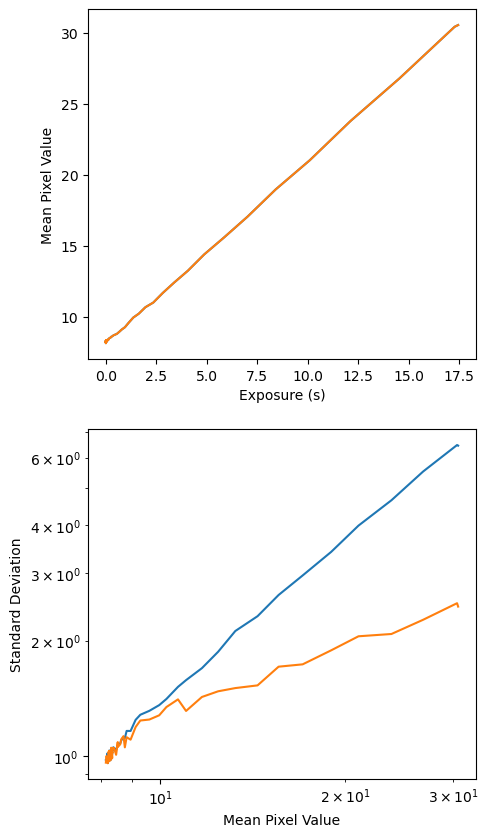

setting black level to 6 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 6
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

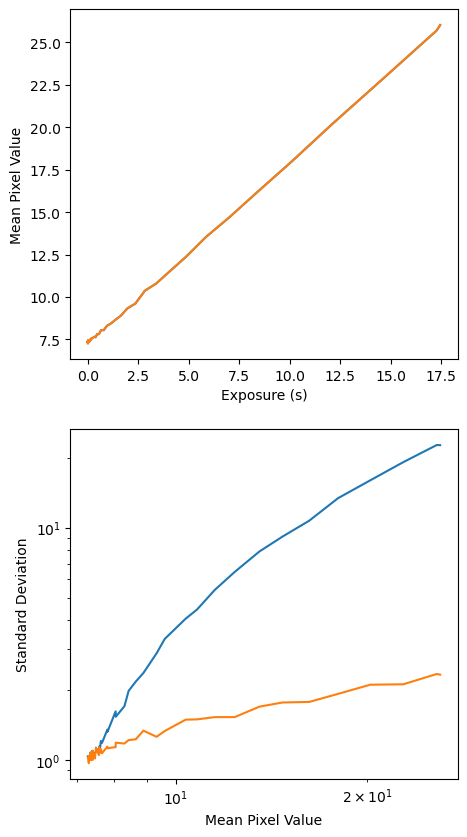

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

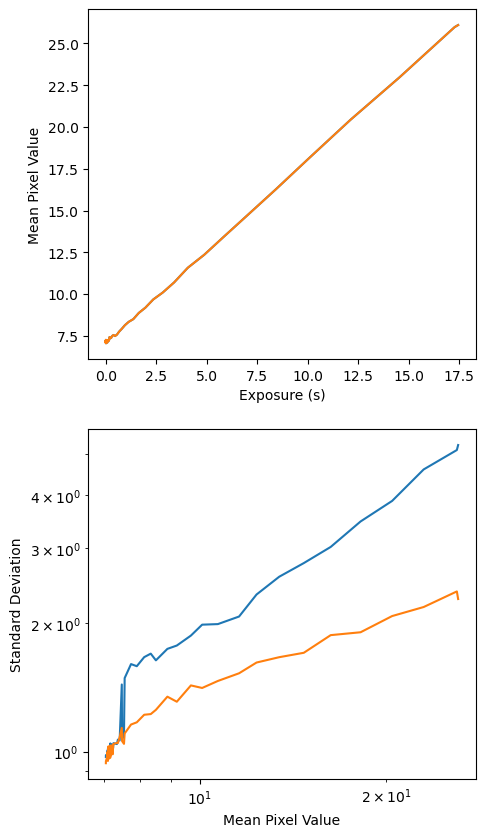

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

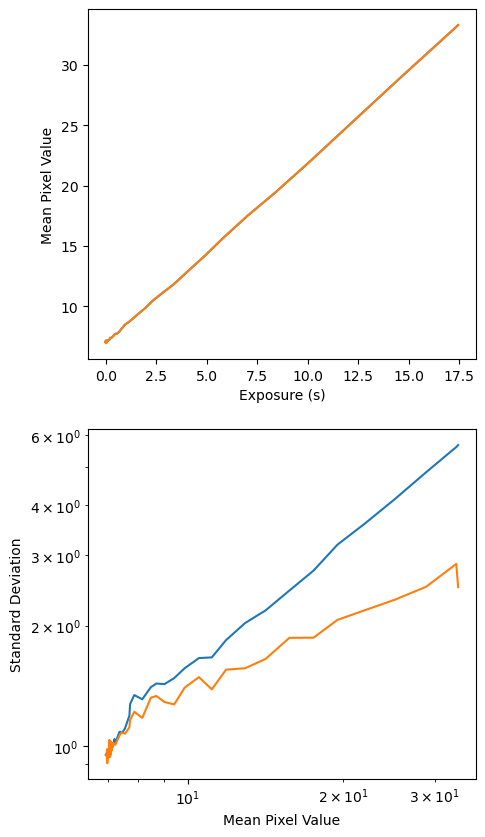

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

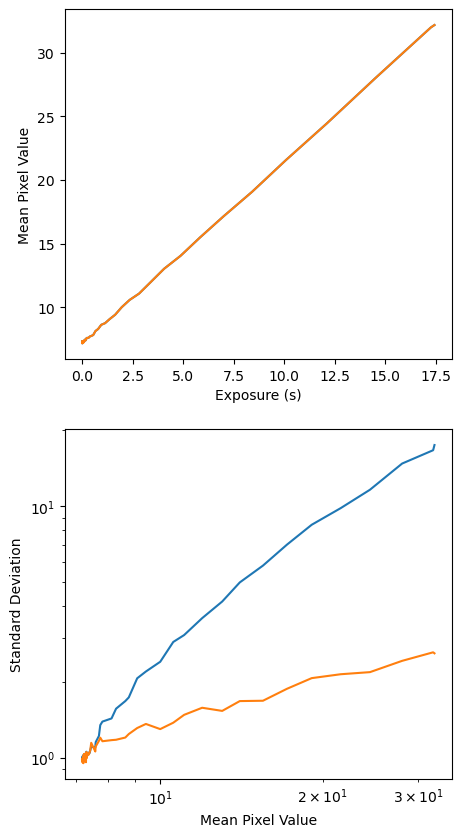

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

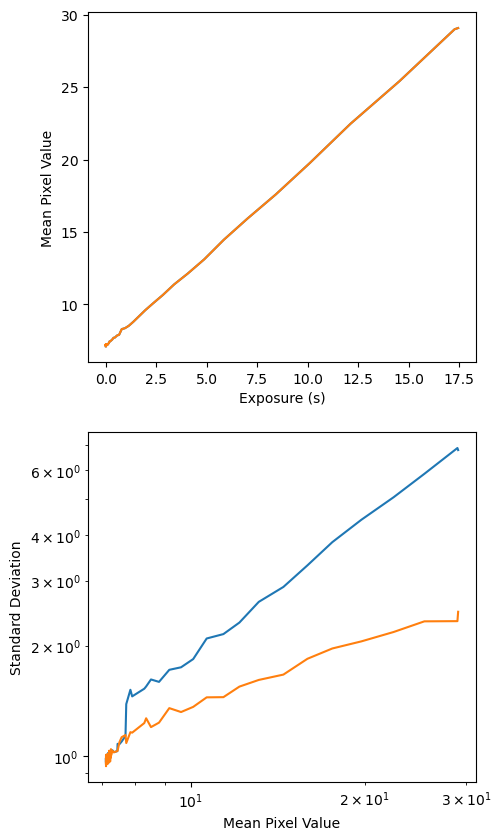

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

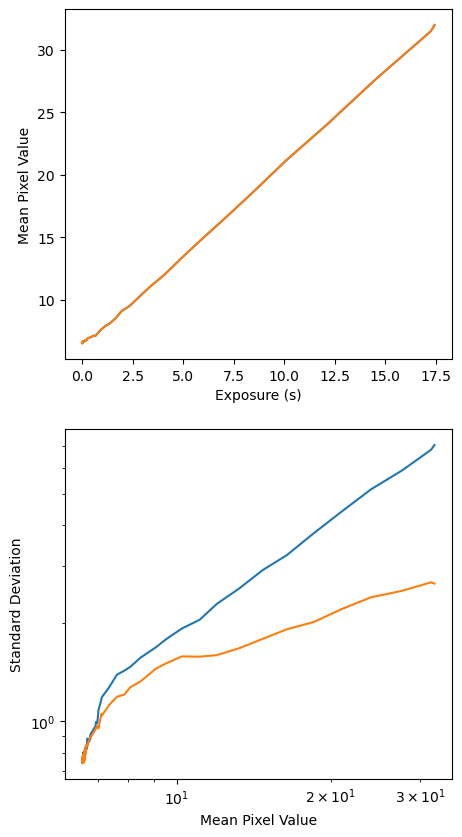

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

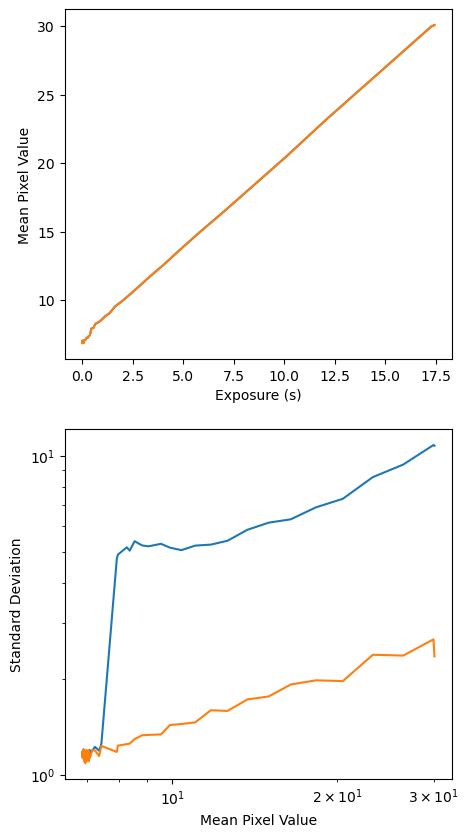

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_6_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_6_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_6_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_6_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

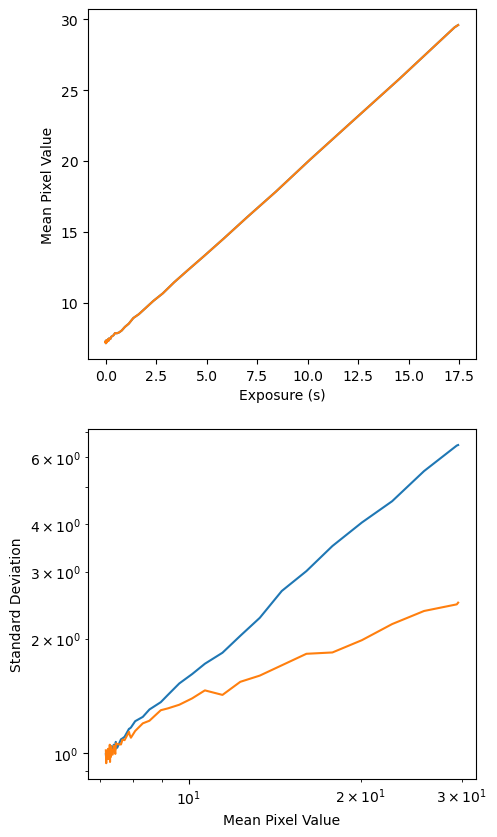

setting black level to 5 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 5
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

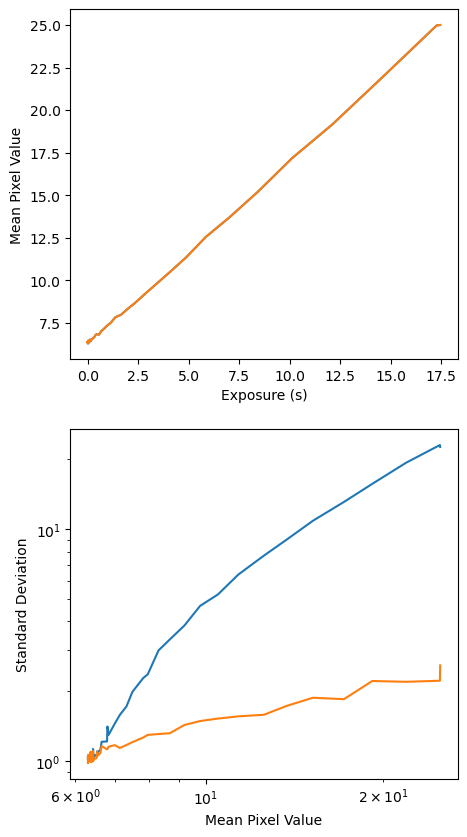

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

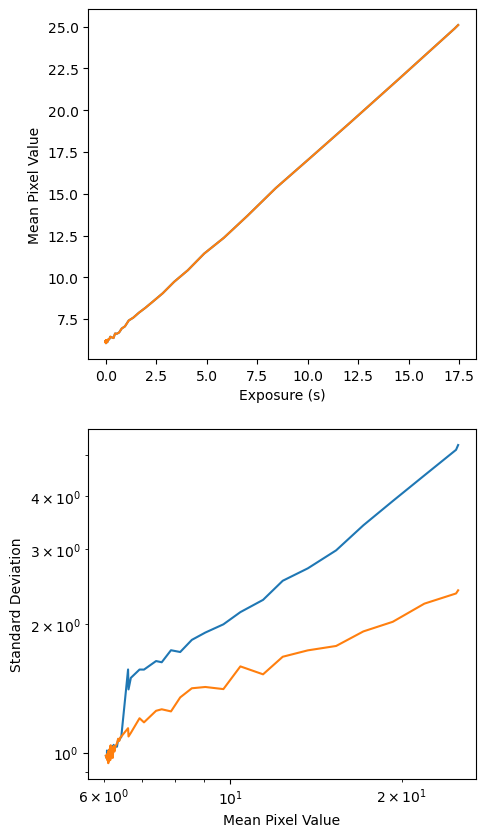

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

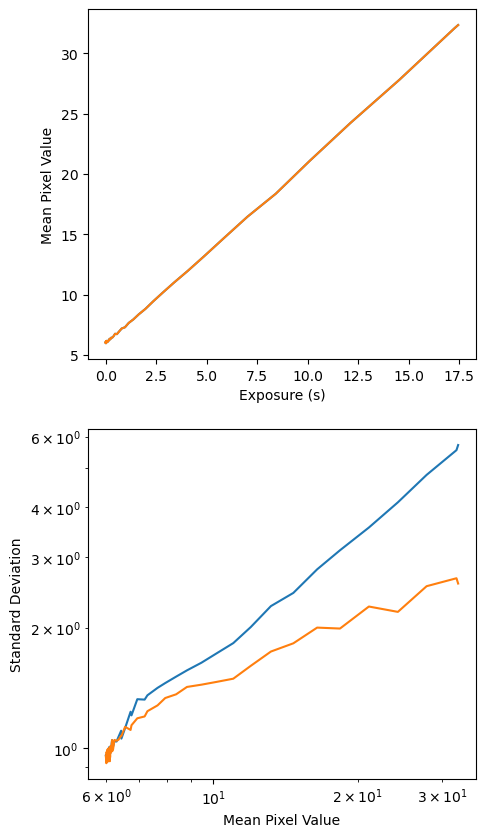

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

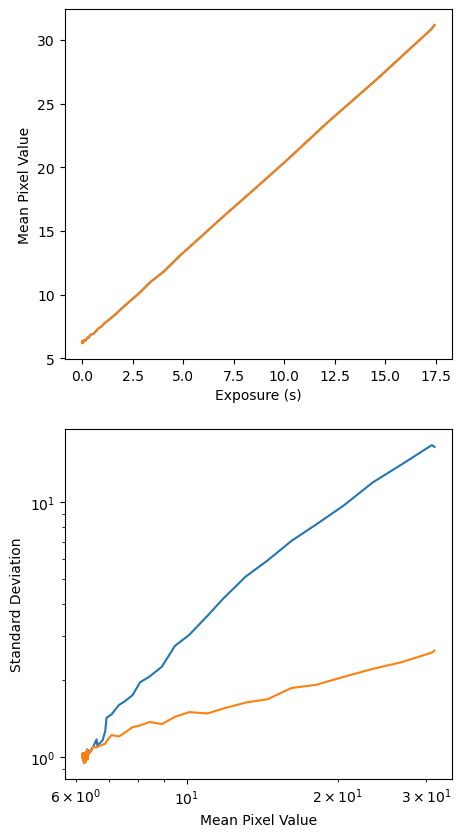

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

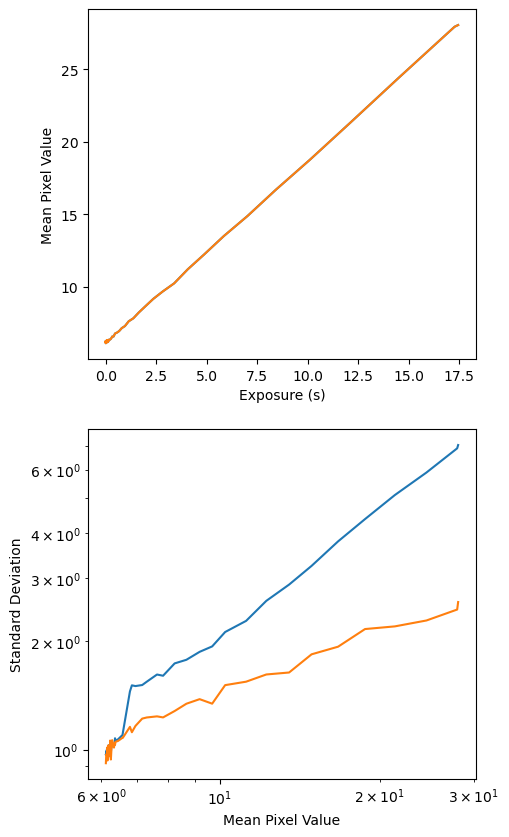

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

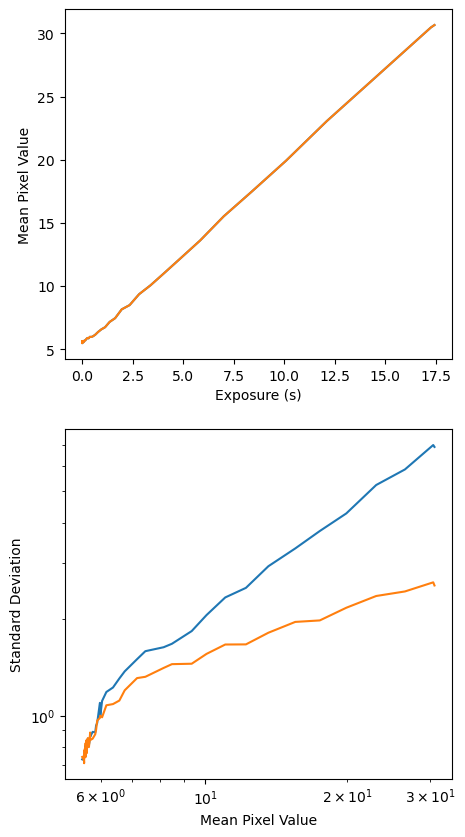

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

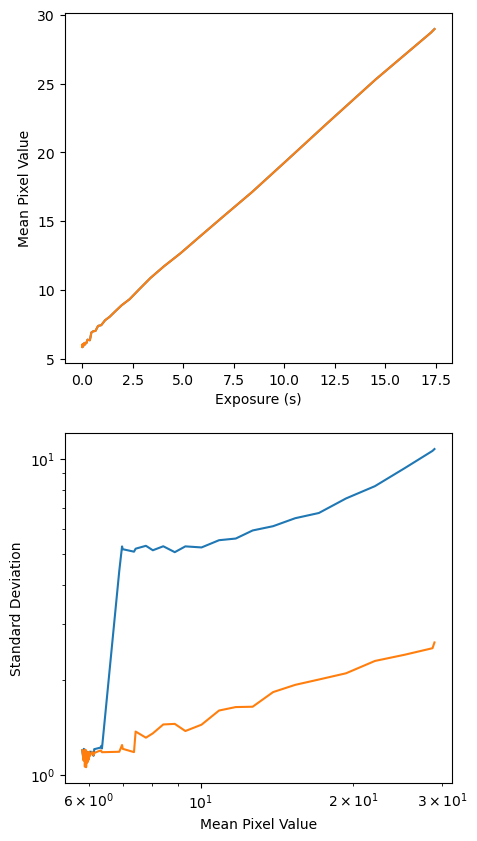

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_5_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_5_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_5_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_5_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

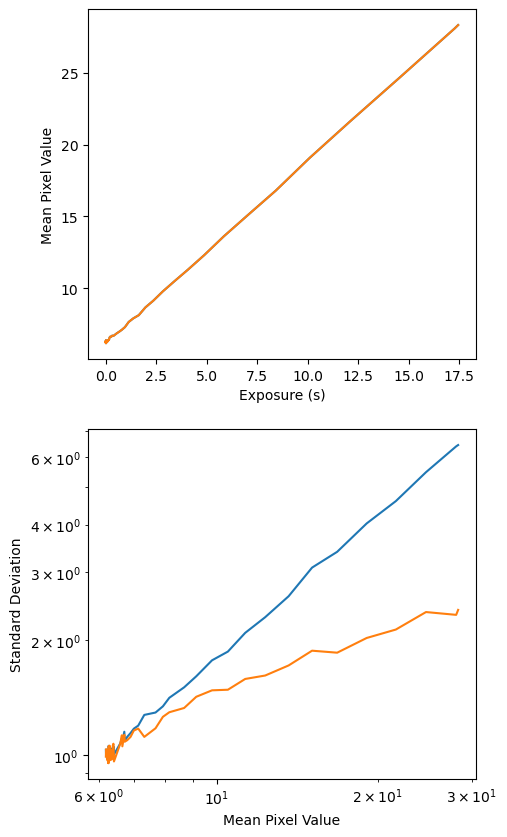

setting black level to 4 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 4
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

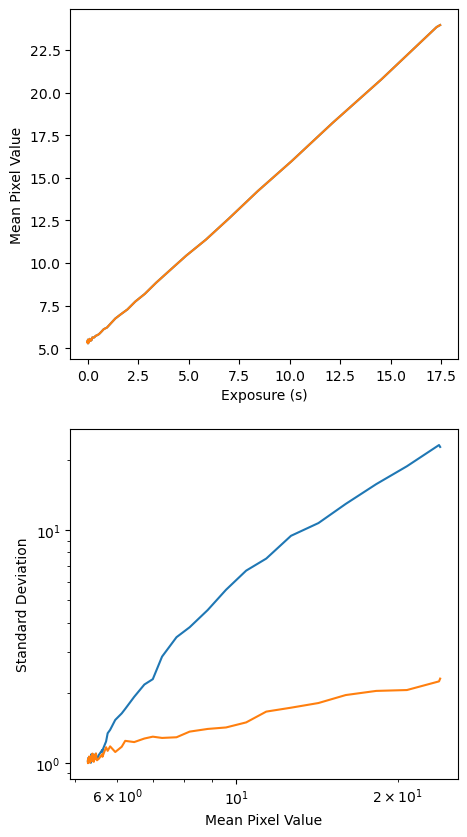

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

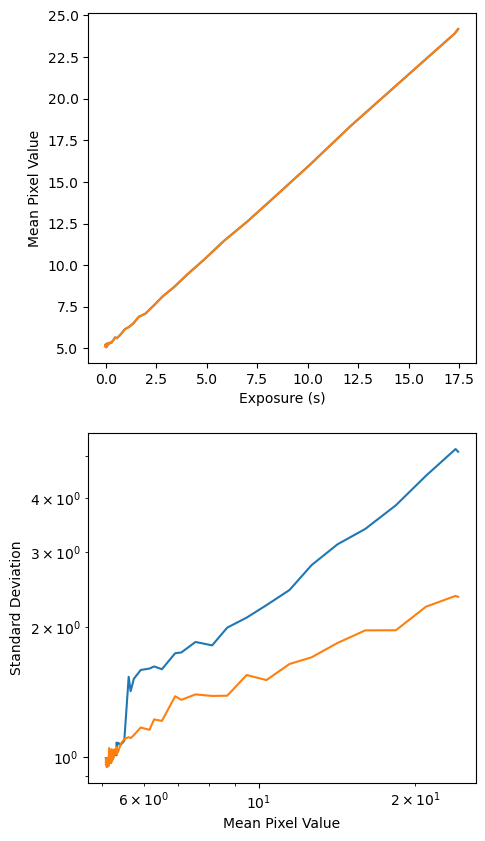

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

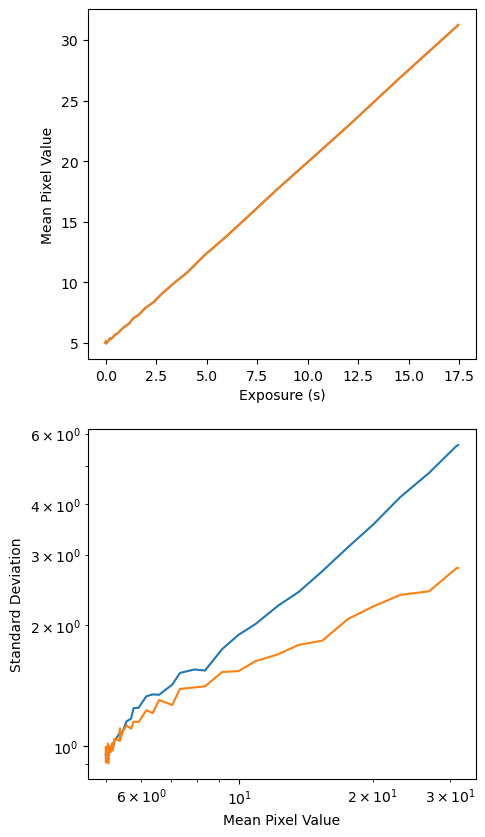

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

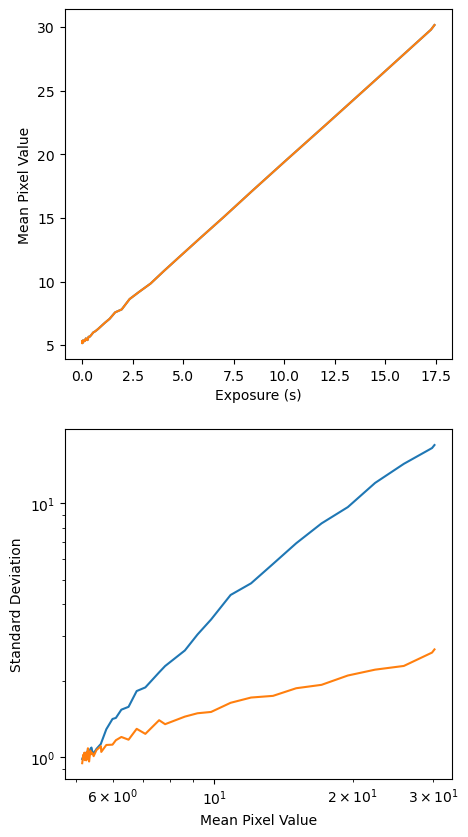

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

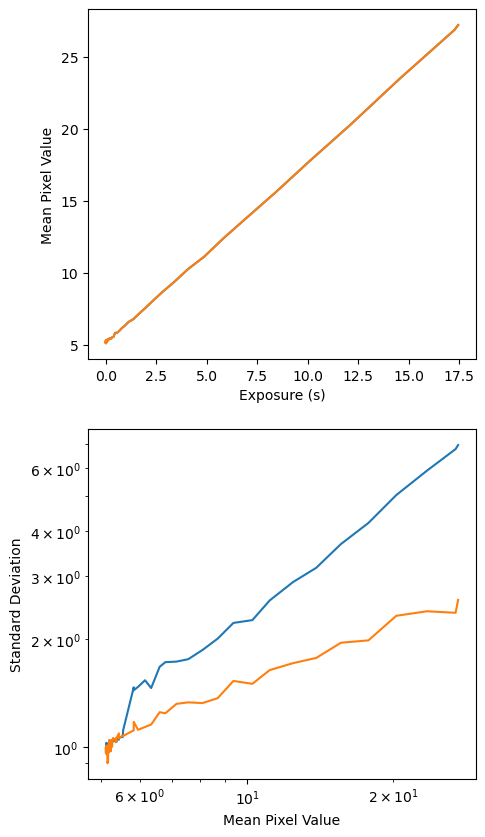

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

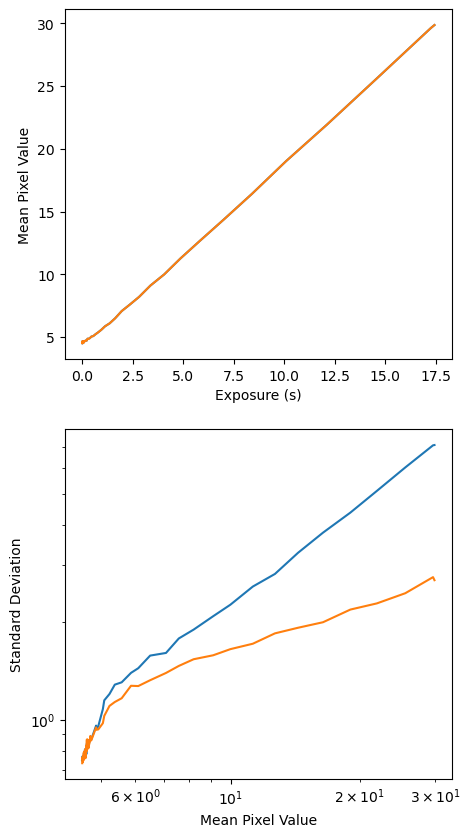

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

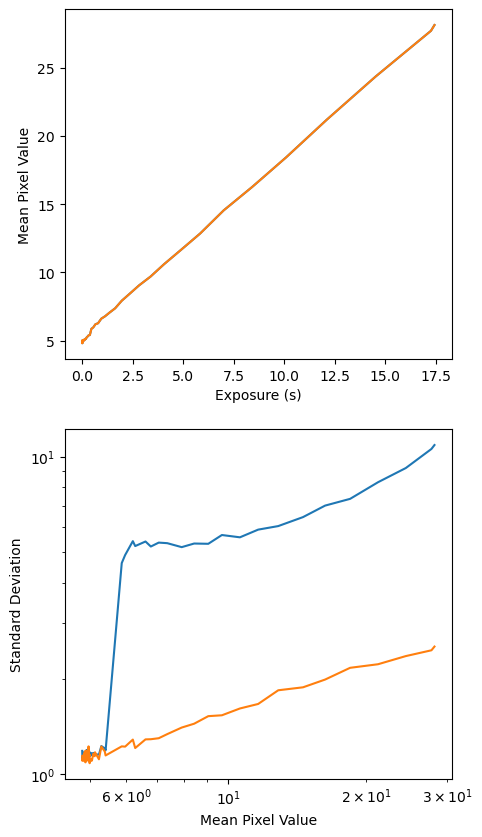

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_4_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_4_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_4_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_4_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

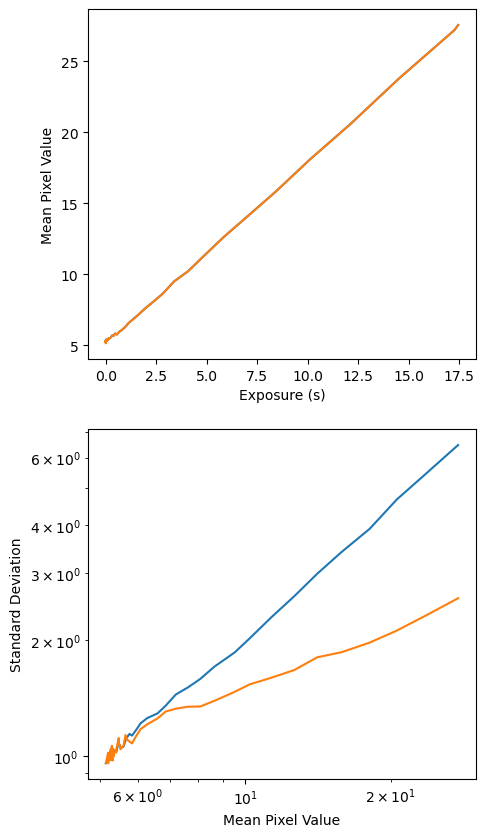

setting black level to 3 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 3
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

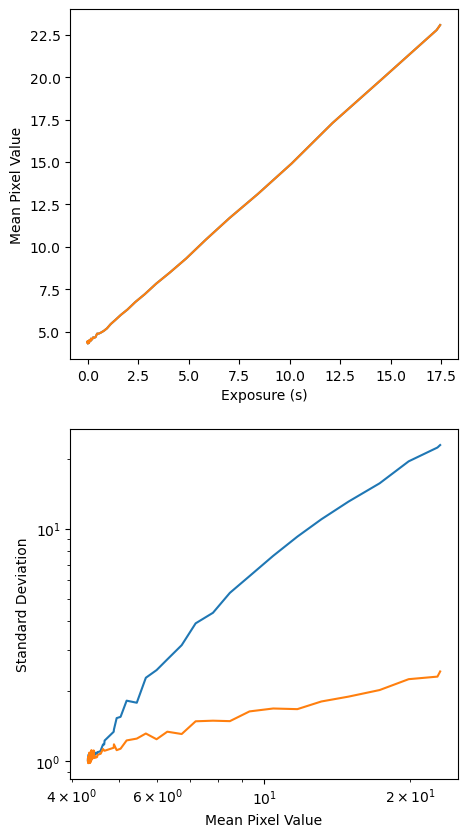

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

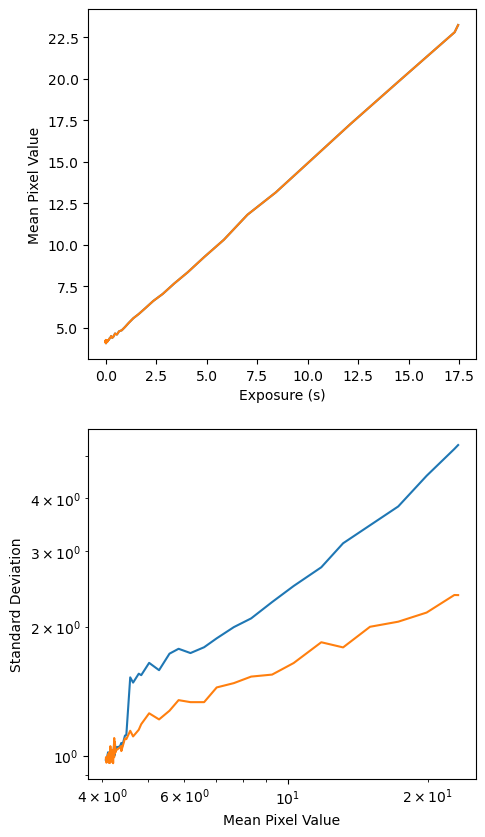

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

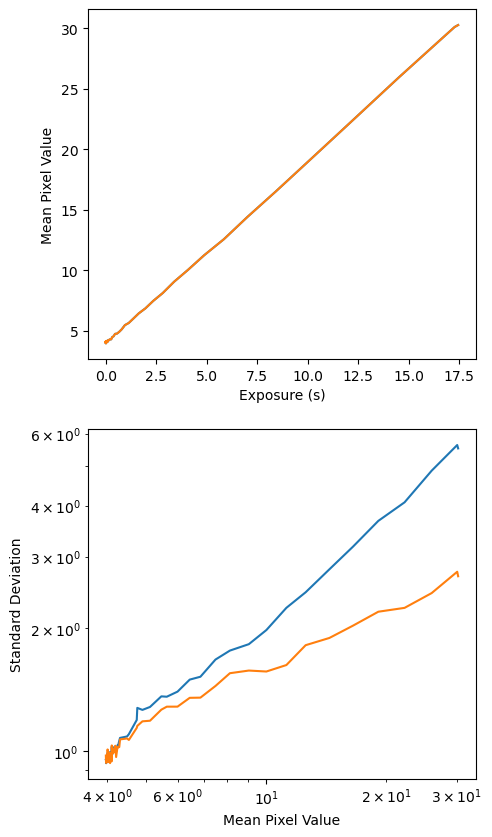

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

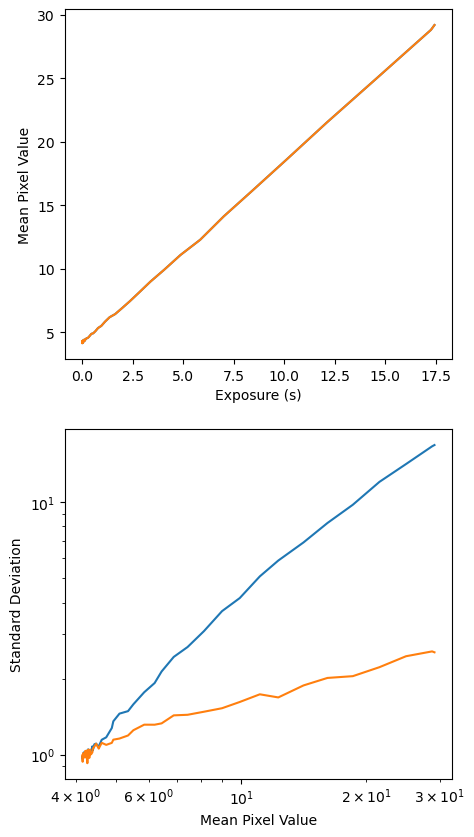

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

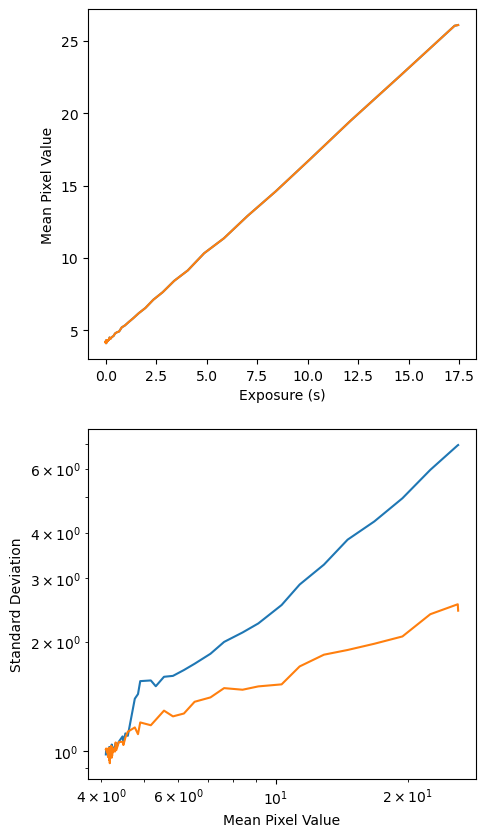

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

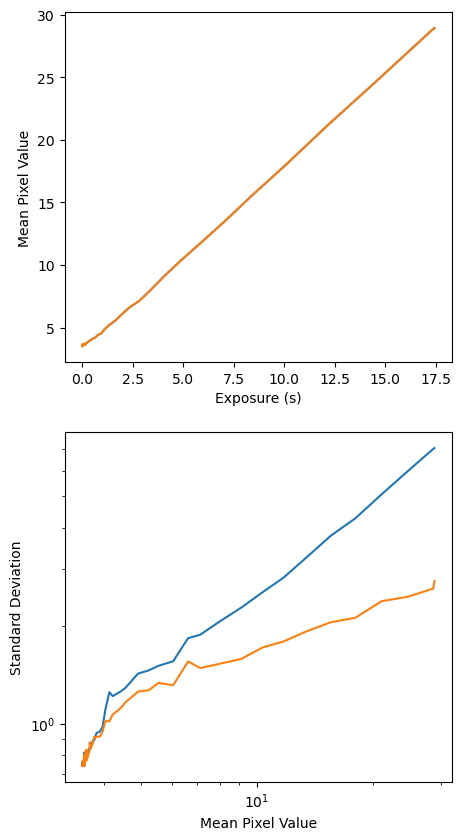

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

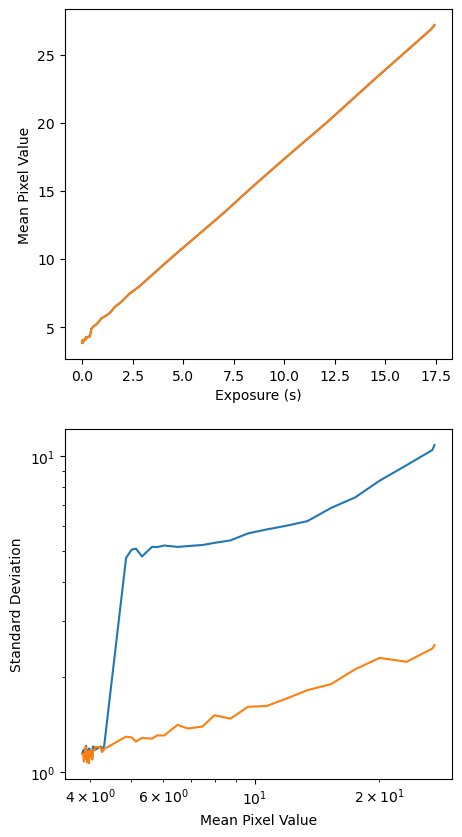

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_3_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_3_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_3_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_3_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

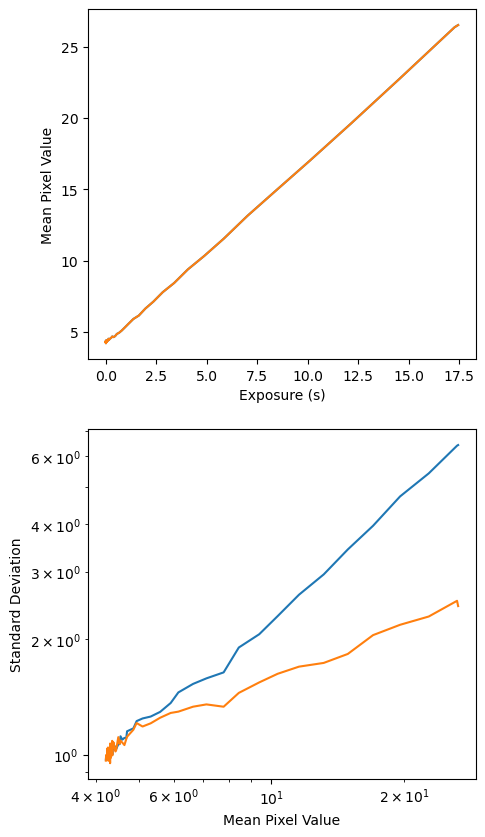

setting black level to 2 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 2
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

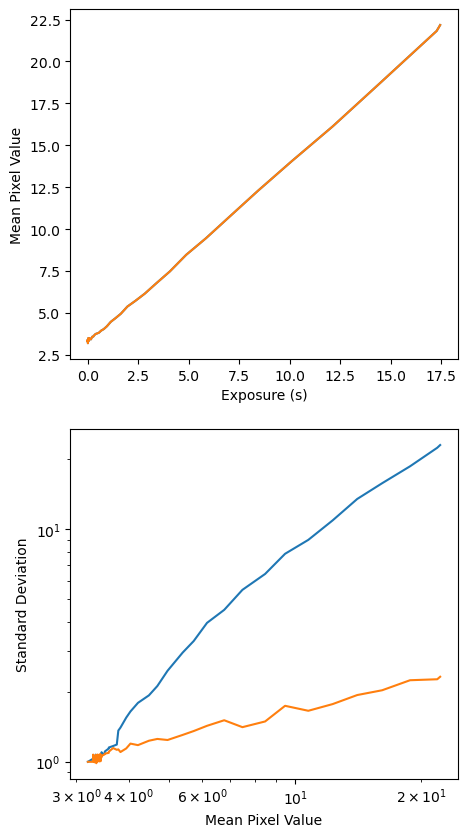

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

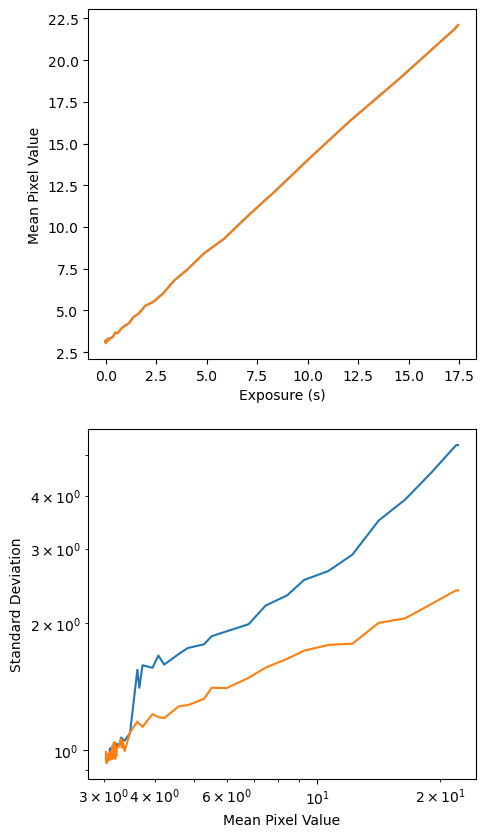

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

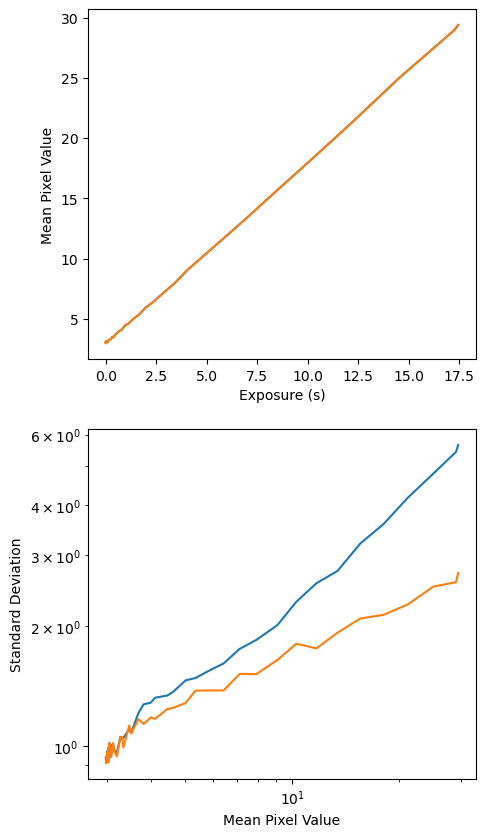

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

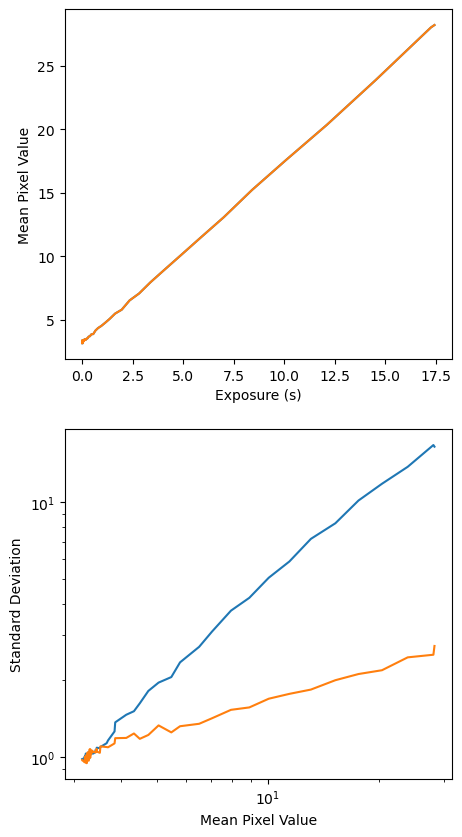

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

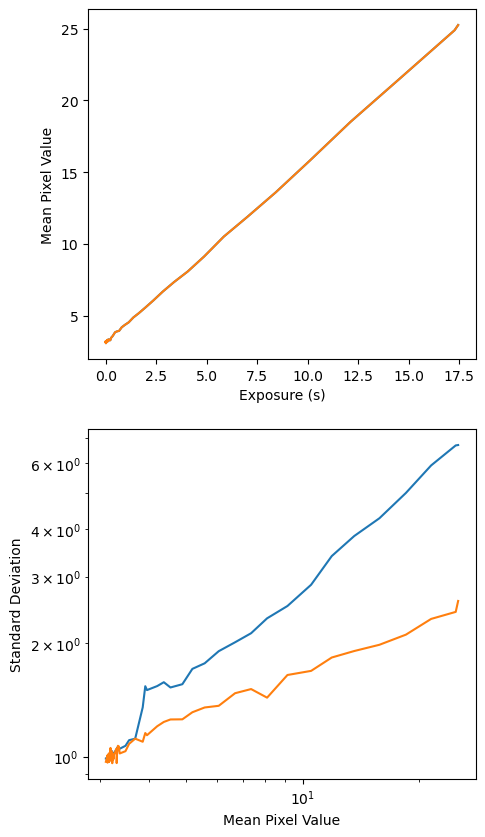

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

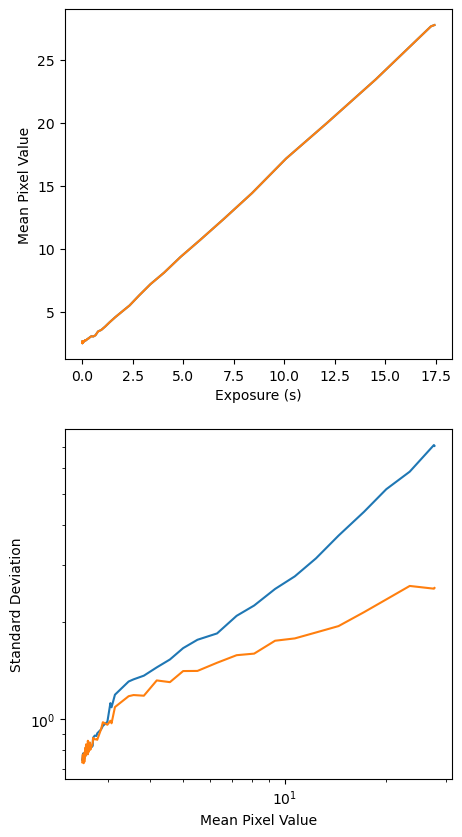

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

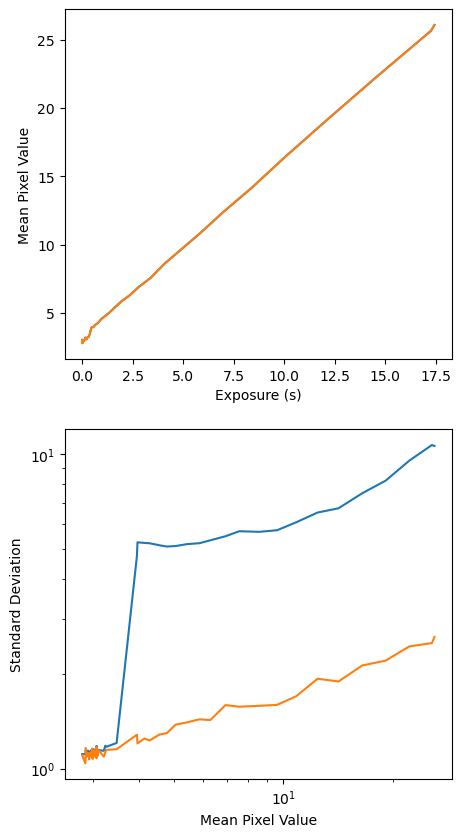

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_2_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_2_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_2_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_2_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

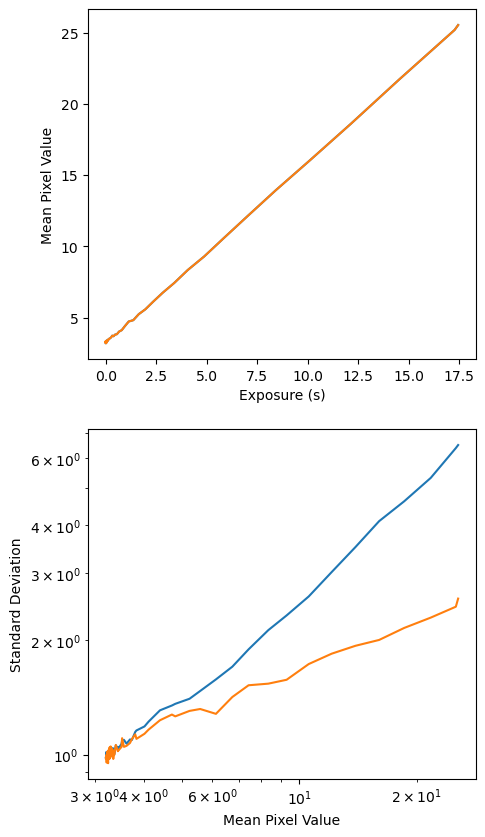

setting black level to 1 DN
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
0
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Image size: 1920 x 1200 pixels
Image buffer size: 36864000 bytes
Bits per pixel: 2
Color Format: SinkFormats.Y16
Frame Rate: 33
Brightness current Value: 1
Contrast current Value: 0
Sharpness current Value: 0
Gamma current Value: 100
Gain current Value: 4.300000190734863
Gain current Auto: 0
Exposure current Value: 0.009998999536037445
Exposure current Auto: 1
Exposure current Auto Reference: 80
Exposure current Auto Max Value: 10.0
Exposure current Auto Max Auto: 0
Trigger current Enable: 0
Denoise current Value: 0
Flip Horizontal current Enable: 0
Flip Vertical current Enable: 0
Highlight Reduction current Enable: 0
Tone Mapping current Enable: 0
Strobe current Enable: 0
Auto Functions ROI curr

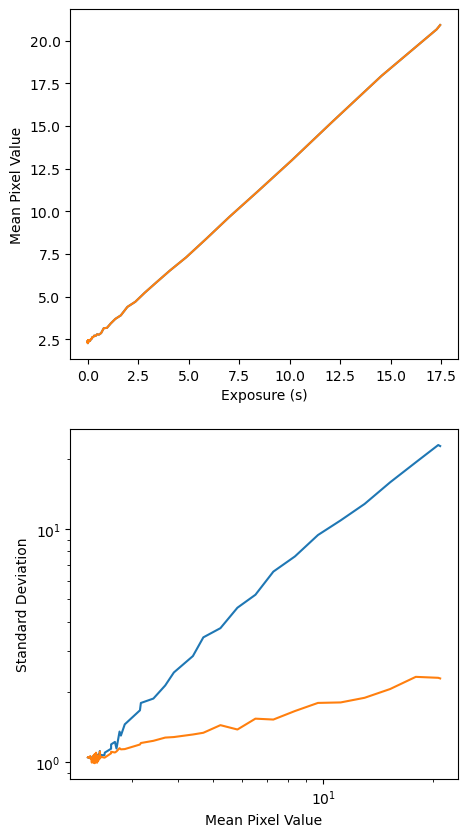

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\1_475\475_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

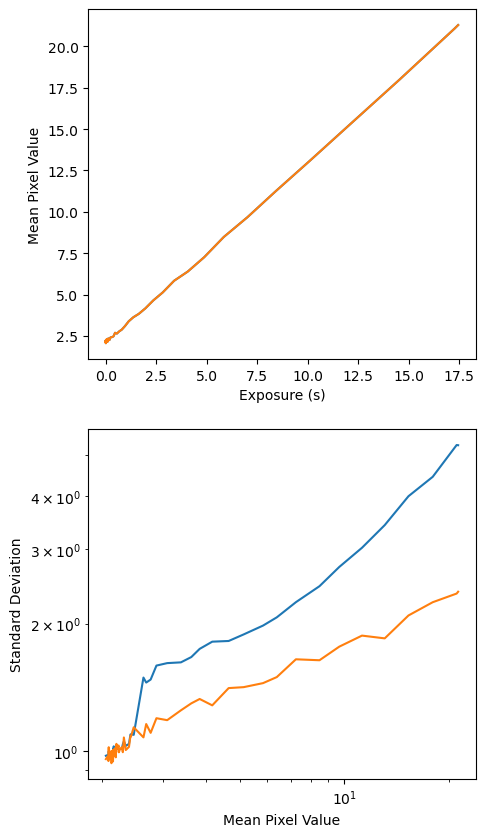

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\2_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\2_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\2_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\2_400\400_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

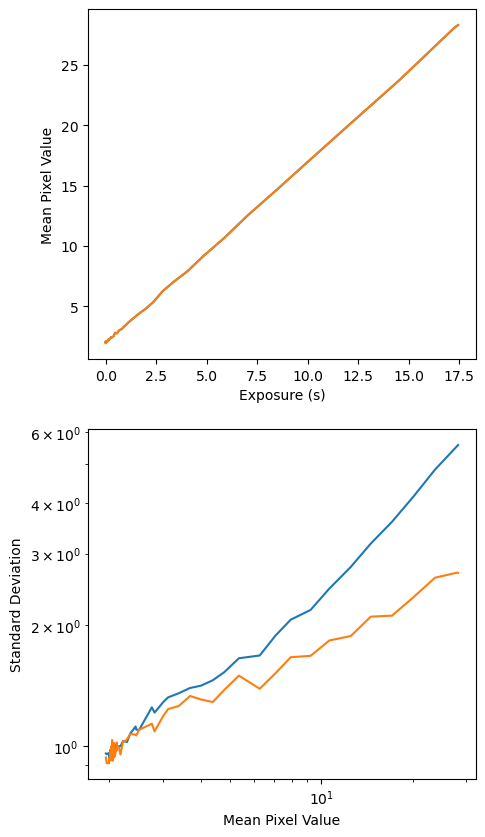

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\3_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\3_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\3_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\3_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

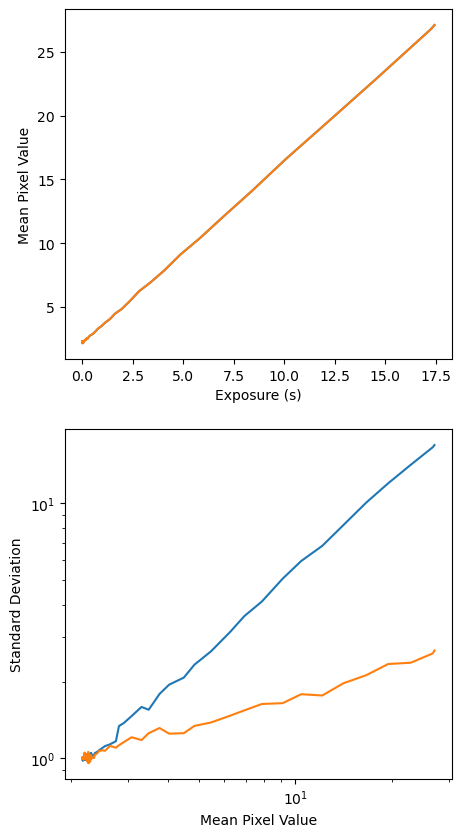

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\4_725\725_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

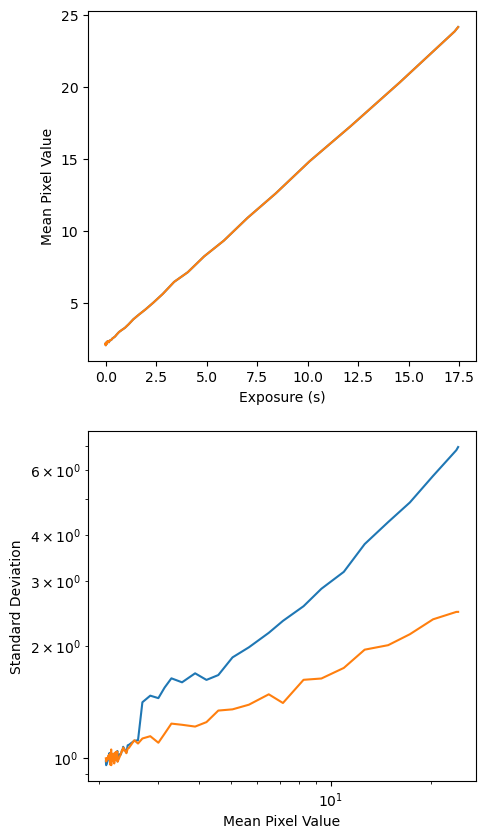

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\5_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\5_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\5_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\5_950\950_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

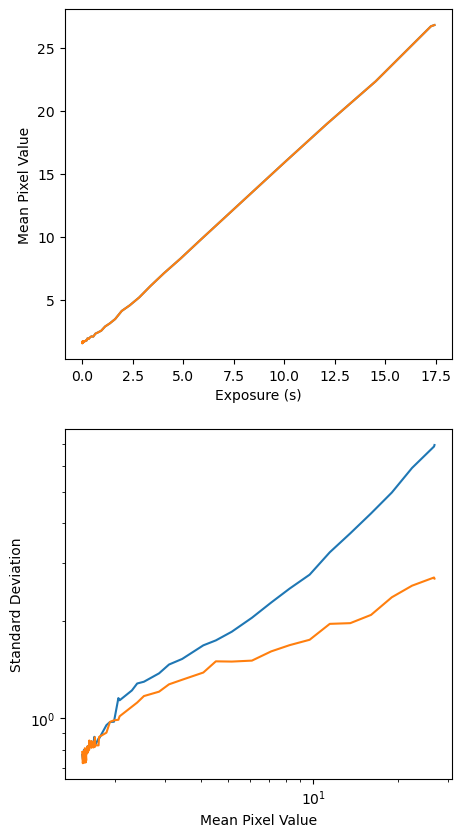

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\7_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\7_550\550_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

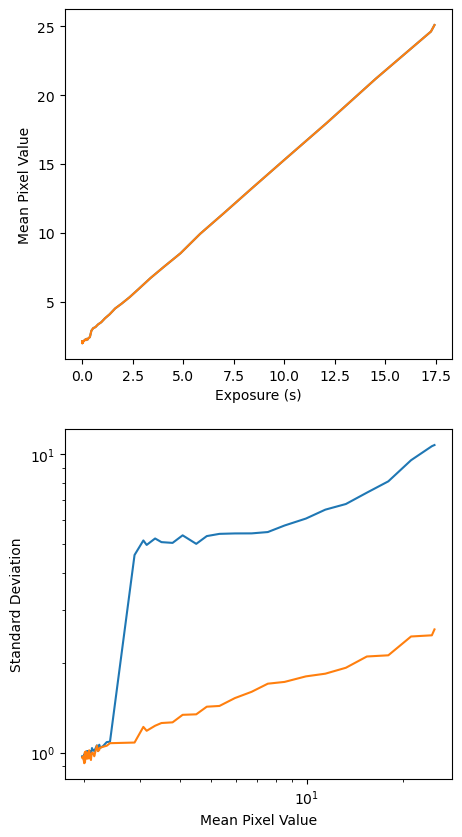

Exposure: 0.0000600 s
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\dark_low_1_300623\6_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\dark_low_1_300623\6_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\dark_low_1_300623\6_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data\dark_low_1_300623\6_650\650_72us_2_calibration.tif
Exposure: 0.0000864 s
Imaging with Exposure:

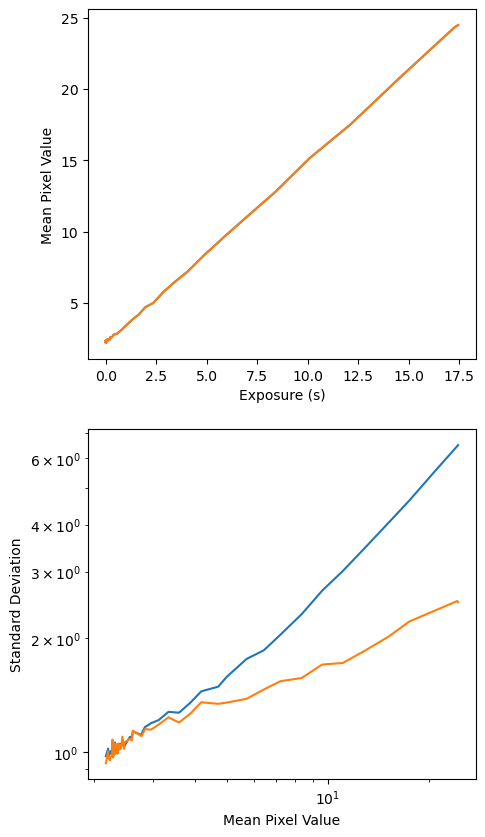

In [5]:
black_levels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
for black_level in black_levels:
    print(f'setting black level to {black_level} DN')
    osc.configure_cameras(cameras, black_level=black_level)
    for camera in cameras:
        dark_exposures = camera_calibration_sequence(camera, f'dark_low_{black_level}_300623')